In [123]:
import os
import glob

from nilearn import plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from nilearn.image import mean_img
from nilearn.plotting import plot_anat

import nibabel as nib

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.callbacks import TensorBoard
from keras.models import Model, Sequential

from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop

from keras import backend as k

from datetime import datetime

In [55]:
#Get data path
data_path = './acerta_whole/classification/*.nii'
files = glob.glob(data_path)

#Get mask path
mask_data = './bkp_acerta/mask_group_whole.nii'

#Get labels
labels = pd.read_csv('./acerta_whole/y.csv', sep=",")
target = labels['Label']

In [56]:
x_coord = 60
y_coord = 73
z_coord = 61

data_all = []
images = []
for data_file in sorted(files):
    #print(data_file)
    data = nib.load(data_file).get_data() 
    #print(type(data))
    #data = data.squeeze()
    #print(data.shape)
    data_all.append(data)
    #data_all.append(data.reshape(x_coord, y_coord, z_coord))
    
images = []    
for i in range(len(files)):
    data = nib.load(files[i])
    data = data.get_data()
    for j in range(data.shape[2]):
        images.append(data[:,:,j])

        
#Load mask file
mask_file = nib.load(mask_data).get_data()
print(mask_file.shape)
#Verify if the whole brain mask is boolean
mask_file = mask_file.astype(bool)

print(len(data_all))

(60, 73, 61)
32


In [57]:
#Preprocessing
#Apply the mask to all the data files
#Maintaining the original structure of the image file

masked_data =[]
for data in data_all:
    masked_data.append(np.array(data * mask_file))

images = np.asarray(masked_data)
print(images.shape)

(32, 60, 73, 61)


In [58]:
#Next, rescale the data with using max-min normalisation technique
ma = np.max(images)
mi = np.min(images)

print(ma, mi)

images = (images - mi) / (ma - mi)

14.318945 -17.862381


In [59]:
#Let's verify the minimum and maximum value of the data which should be 0.0 and 1.0 after rescaling it!
print(np.min(images), np.max(images))

0.0 1.0


In [60]:
# Create list of indices and shuffle them
N = images.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)

#  Cut the dataset at 80% to create the training and test set
N_80p = int(0.8 * N)
indices_train = indices[:N_80p]
indices_test = indices[N_80p:]

# Split the data into training and test sets
X_train = images[indices_train, ...]
X_test = images[indices_test, ...]

print(X_train.shape, X_test.shape)

(25, 60, 73, 61) (7, 60, 73, 61)


In [88]:
# Create outcome variable
y_train = target[indices_train] 
y_test  = target[indices_test]
print(y_train.shape)
print(y_test)

(25,)
25    0
29    0
2     1
27    0
19    0
14    1
22    0
Name: Label, dtype: int64


In [62]:
# Create a sequential model

# Get shape of input data
data_shape = tuple(X_train.shape[1:])
print(data_shape)

# Specify shape of convolution kernel
kernel_size = (3, 3)

# Specify number of output categories
n_classes = 2

# Specify number of filters per layer
filters = 16

(60, 73, 61)


In [63]:
k.clear_session()
model = Sequential()

model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=data_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(filters * 2, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(filters * 4, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# optimizer
learning_rate = 1e-5
adam = Adam(lr=learning_rate)
sgd = SGD(lr=learning_rate)

model.compile(loss='binary_crossentropy',
              optimizer=adam, # swap out for sgd 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 71, 16)        8800      
_________________________________________________________________
batch_normalization_1 (Batch (None, 58, 71, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 35, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 33, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 27, 33, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 14, 64)        18496     
__________

In [64]:
#Fitting the Model

#The next step is now of course to fit our model to the training data. 
#In our case we have two parameters that we can work with:

#First: How many iterations of the model fitting should be computed
nEpochs = 100  # Increase this value for better results (i.e., more training)

#Second: How many elements (volumes) should be considered at once for the updating of the weights?

batch_size = 16   # Increasing this value might speed up fitting

In [124]:
# TensorBoard callback
LOG_DIRECTORY_ROOT = 'logdir'
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
log_dir = "{}/run-{}/".format(LOG_DIRECTORY_ROOT, now)
tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, write_images=True)

# Place the callbacks in a list
callbacks = [tensorboard]

In [65]:
# Let's test the model:

%time fit = model.fit(X_train, y_train, epochs=nEpochs, batch_size=batch_size)

Epoch 1/100
25/25 [==============================] - 1s 33ms/step - loss: 0.9929 - acc: 0.6400
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 1.1880 - acc: 0.4800
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.9424 - acc: 0.5600
Epoch 4/100
25/25 [==============================] - 0s 4ms/step - loss: 1.1670 - acc: 0.4000
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 1.0517 - acc: 0.4400
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.7375 - acc: 0.5600
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 1.0155 - acc: 0.4800
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6750 - acc: 0.6800
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss: 1.2355 - acc: 0.3600
Epoch 10/100
25/25 [==============================] - 0s 3ms/step - loss: 0.7335 - acc: 0.5600
Epoch 11/100
25/25 [==============================] - 0s 3

25/25 [==============================] - 0s 3ms/step - loss: 0.2692 - acc: 0.8000
Epoch 88/100
25/25 [==============================] - 0s 3ms/step - loss: 0.3633 - acc: 0.8400
Epoch 89/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4189 - acc: 0.7600
Epoch 90/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4530 - acc: 0.8400
Epoch 91/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4768 - acc: 0.7600
Epoch 92/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7915 - acc: 0.6800
Epoch 93/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5626 - acc: 0.6400
Epoch 94/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5530 - acc: 0.7600
Epoch 95/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2886 - acc: 0.8800
Epoch 96/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4411 - acc: 0.6800
Epoch 97/100
25/25 [==============================] - 0s 2ms/st

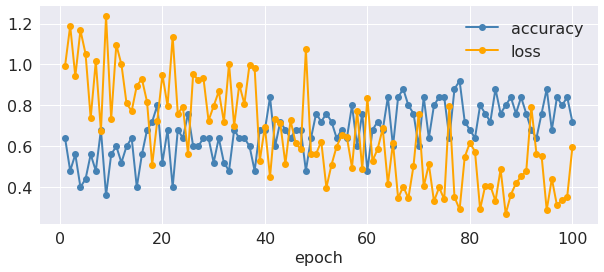

In [66]:
#Let's take a look at the loss and accuracy values during the different epochs:
fig = plt.figure(figsize=(10, 4))
epoch = np.arange(nEpochs) + 1
fontsize = 16
plt.plot(epoch, fit.history['acc'], marker="o", linewidth=2,
         color="steelblue", label="accuracy")
plt.plot(epoch, fit.history['loss'], marker="o", linewidth=2,
         color="orange", label="loss")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16)

In [67]:
# Evaluating the model

evaluation = model.evaluate(X_test, y_test)
print('Loss in Test set:      %.02f' % (evaluation[0]))
print('Accuracy in Test set:  %.02f' % (evaluation[1] * 100))

7/7 [==============================] - 0s 25ms/step
Loss in Test set:      0.90
Accuracy in Test set:  28.57


In [83]:
# Run more model iterations

nEpochs = 200

%time fit = model.fit(X_train, y_train, epochs=nEpochs, batch_size=batch_size)

Epoch 1/200
25/25 [==============================] - 0s 4ms/step - loss: 0.1196 - acc: 0.9600
Epoch 2/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0986 - acc: 1.0000
Epoch 3/200
25/25 [==============================] - 0s 2ms/step - loss: 0.1131 - acc: 1.0000
Epoch 4/200
25/25 [==============================] - 0s 3ms/step - loss: 0.1269 - acc: 0.9600
Epoch 5/200
25/25 [==============================] - 0s 3ms/step - loss: 0.1928 - acc: 0.9200
Epoch 6/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0690 - acc: 1.0000
Epoch 7/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - acc: 1.0000
Epoch 8/200
25/25 [==============================] - 0s 3ms/step - loss: 0.1169 - acc: 0.9600
Epoch 9/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0926 - acc: 0.9600
Epoch 10/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0912 - acc: 1.0000
Epoch 11/200
25/25 [==============================] - 0s 3m

25/25 [==============================] - 0s 3ms/step - loss: 0.0469 - acc: 1.0000
Epoch 88/200
25/25 [==============================] - 0s 4ms/step - loss: 0.0512 - acc: 1.0000
Epoch 89/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - acc: 1.0000
Epoch 90/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0688 - acc: 1.0000
Epoch 91/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - acc: 1.0000
Epoch 92/200
25/25 [==============================] - 0s 3ms/step - loss: 0.1379 - acc: 0.9600
Epoch 93/200
25/25 [==============================] - 0s 3ms/step - loss: 0.1576 - acc: 0.9200
Epoch 94/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0502 - acc: 1.0000
Epoch 95/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0753 - acc: 1.0000
Epoch 96/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0877 - acc: 1.0000
Epoch 97/200
25/25 [==============================] - 0s 3ms/st

25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - acc: 1.0000
Epoch 173/200
25/25 [==============================] - 0s 2ms/step - loss: 0.0551 - acc: 1.0000
Epoch 174/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0695 - acc: 1.0000
Epoch 175/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0705 - acc: 0.9600
Epoch 176/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0812 - acc: 1.0000
Epoch 177/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0275 - acc: 1.0000
Epoch 178/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0570 - acc: 1.0000
Epoch 179/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - acc: 1.0000
Epoch 180/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0548 - acc: 1.0000
Epoch 181/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0335 - acc: 1.0000
Epoch 182/200
25/25 [==============================] -

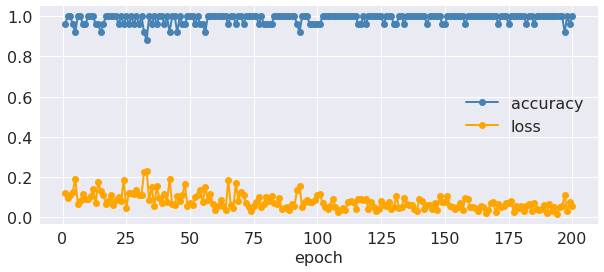

In [84]:
fig = plt.figure(figsize=(10, 4))
epoch = np.arange(nEpochs) + 1
fontsize = 16
plt.plot(epoch, fit.history['acc'], marker="o", linewidth=2,
         color="steelblue", label="accuracy")
plt.plot(epoch, fit.history['loss'], marker="o", linewidth=2,
         color="orange", label="loss")
plt.xlabel('epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

In [85]:
# Wow, much better! At least on the training data. What about the test data?

evaluation = model.evaluate(X_test, y_test)
print('Loss in Test set:      %.02f' % (evaluation[0]))
print('Accuracy in Test set:  %.02f' % (evaluation[1] * 100))

7/7 [==============================] - 0s 3ms/step
Loss in Test set:      1.09
Accuracy in Test set:  42.86


In [97]:
# Analyze prediction values

y_pred = model.predict(X_test)
y_pred[:,:]

array([[0.9466407 ],
       [0.77059275],
       [0.68860364],
       [0.62368214],
       [0.6863713 ],
       [0.83647585],
       [0.43486804]], dtype=float32)

In [125]:
rounded = [round(x[0]) for x in y_pred]
print(rounded)
y_pred = np.array(y_pred)
print([x for x in y_pred[:,0] if x > 0.5])
print([x for x in y_pred[:,0] if x < 0.5])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
[0.9466407, 0.77059275, 0.68860364, 0.62368214, 0.6863713, 0.83647585]
[0.43486804]


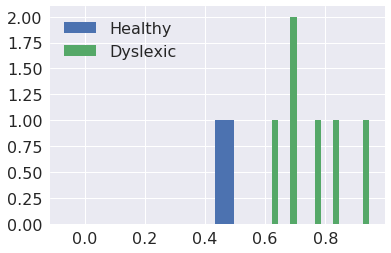

In [121]:
fig = plt.figure(figsize=(6, 4))
fontsize = 16
plt.hist([x for x in y_pred[:,0] if x < 0.5], bins=16, label='Healthy')
plt.hist([x for x in y_pred[:,0] if x > 0.5], bins=16, label='Dyslexic');
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(frameon=False, fontsize=16);

In [73]:
#Visualizing Hidden Layers

#Finally, as a cool additional feature: We can now visualize the individual filters of the hidden layers.
#So let's get to it:

# Aggregate the layers
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [90]:
# Specify a function that visualized the layers
def show_activation(layer_name):
    
    layer_output = layer_dict[layer_name].output

    fn = k.function([model.input], [layer_output])
    
    inp = X_train[0:1]
    
    this_hidden = fn([inp])[0]
    
    # plot the activations, 8 filters per row
    plt.figure(figsize=(16,8))
    nFilters = this_hidden.shape[-1]
    nColumn = 8 if nFilters >= 8 else nFilters
    for i in range(nFilters):
        plt.subplot(nFilters / nColumn, nColumn, i+1)
        plt.imshow(this_hidden[0,:,:,i], cmap='magma', interpolation='nearest')
        plt.axis('off')
    
    return

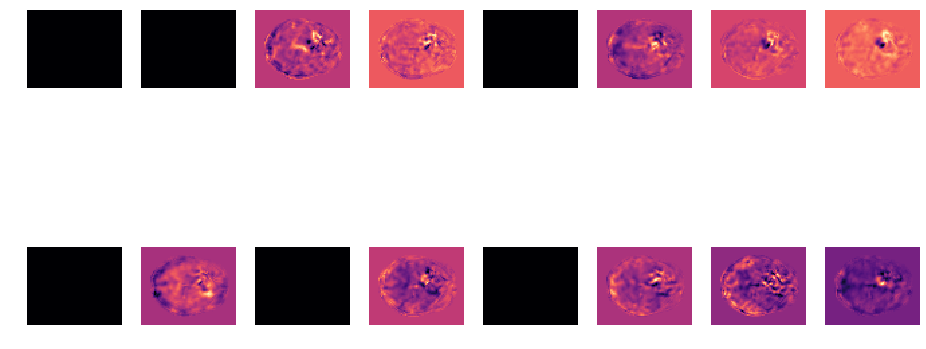

In [91]:
#Now we can plot the filters of the hidden layers:

show_activation('conv2d_1')

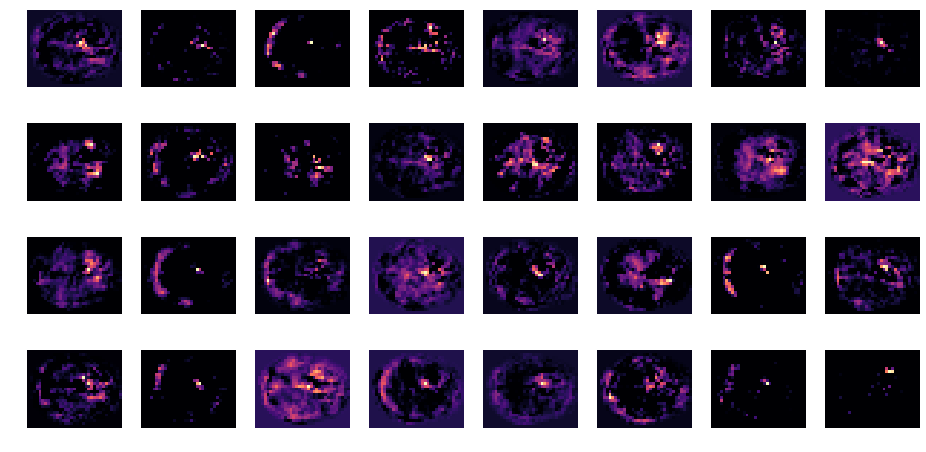

In [92]:
show_activation('conv2d_2')

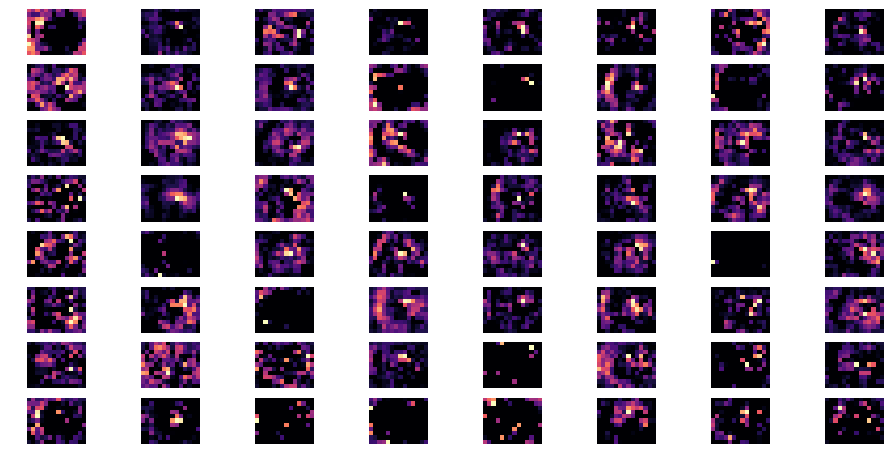

In [79]:
show_activation('conv2d_3')

In [140]:
# Modelo 3D

data_all = []
for data_file in sorted(files):
    data = nib.load(data_file).get_data() 
    data_all.append(data)

        
#Load mask file
mask_file = nib.load(mask_data).get_data()
print(mask_file.shape)
#Verify if the whole brain mask is boolean
mask_file = mask_file.astype(bool)

#Preprocessing
#Apply the mask to all the data files
#Maintaining the original structure of the image file

masked_data =[]
for data in data_all:
    aux = np.expand_dims(np.array(data * mask_file), axis=0)
    masked_data.append(aux)

images = np.asarray(masked_data)
print(images.shape)
images = np.rollaxis(images, 1, 5)
print(images.shape)

(60, 73, 61)
(32, 1, 60, 73, 61)
(32, 60, 73, 61, 1)


In [141]:
#Split data into a training and testing set

#The splitting of the data into training and test set is exactly the same as before.

# Create list of indices and shuffle them
N = images.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)

#  Cut the dataset at 80% to create the training and test set
N_80p = int(0.8 * N)
indices_train = indices[:N_80p]
indices_test = indices[N_80p:]

# Split the data into training and test sets
X_train = images[indices_train, ...]
X_test = images[indices_test, ...]

print(X_train.shape, X_test.shape)

(25, 60, 73, 61, 1) (7, 60, 73, 61, 1)


In [143]:
#Create outcome variable

#Also here, everything is the same as in the 2D example.

y_train = target[indices_train]
y_test = target[indices_test]

In [144]:
import tensorflow as tf
from keras.models import Sequential

from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv3D, MaxPooling3D, BatchNormalization

from keras.optimizers import Adam, SGD

from keras import backend as K

In [145]:
# Get shape of input data
data_shape = tuple(X_train.shape[1:])

# Specify shape of convolution kernel
kernel_size = (3, 3, 2)

# Specify number of output categories
n_classes = 2

# Specify number of filters per layer
filters = 16  # For better results, increase this value to 8

In [146]:
# Create model
K.clear_session()
model = Sequential()

model.add(Conv3D(filters, kernel_size, activation='relu', input_shape=data_shape,
                 strides=(3, 3, 2)))
model.add(BatchNormalization())
model.add(MaxPooling3D())

model.add(Conv3D(filters * 2, kernel_size, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 1)))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

# optimizer
learning_rate = 1e-5
adam = Adam(lr=learning_rate)
sgd = SGD(lr=learning_rate)

model.compile(loss='binary_crossentropy',
              optimizer=adam, # swap out for sgd 
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 24, 30, 16)    304       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 24, 30, 16)    64        
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 12, 15, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 8, 10, 14, 32)     9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 10, 14, 32)     128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 4, 5, 14, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8960)              0         
__________

In [160]:
# Fitting the model
nEpochs = 50
batch_size = 10

In [148]:
run_3D_convnet = True

In [161]:
%time 
if run_3D_convnet:
    fit = model.fit(X_train, y_train, epochs=nEpochs, batch_size=batch_size)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 45.8 µs
Epoch 1/50
25/25 [==============================] - 0s 5ms/step - loss: 0.0242 - acc: 1.0000
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0242 - acc: 1.0000
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0255 - acc: 1.0000
Epoch 4/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0267 - acc: 1.0000
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0180 - acc: 1.0000
Epoch 6/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0179 - acc: 1.0000
Epoch 7/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0325 - acc: 1.0000
Epoch 8/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0271 - acc: 1.0000
Epoch 9/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0247 - acc: 1.0000
Epoch 10/50
25/25 [==============================] - 0s 4ms/step - loss: 0.0629 - acc: 0.9600
Epoch

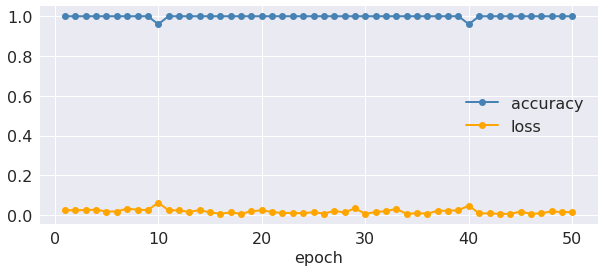

In [163]:
# Performance during model fitting
if run_3D_convnet:
    fig = plt.figure(figsize=(10, 4))
    epoch = np.arange(nEpochs) + 1
    fontsize = 16
    plt.plot(epoch, fit.history['acc'], marker="o", linewidth=2,
             color="steelblue", label="accuracy")
    plt.plot(epoch, fit.history['loss'], marker="o", linewidth=2,
             color="orange", label="loss")
    plt.xlabel('epoch', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.legend(frameon=False, fontsize=16)

In [164]:
# Evaluating the model
if run_3D_convnet:
    evaluation = model.evaluate(X_test, y_test)
    print('Loss in Test set:      %.02f' % (evaluation[0]))
    print('Accuracy in Test set:  %.02f' % (evaluation[1] * 100))

7/7 [==============================] - 0s 3ms/step
Loss in Test set:      1.15
Accuracy in Test set:  57.14


In [178]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[10].reshape(1,60,73,61,1))
print(activations[0].shape)
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, :, activation_index], cmap='gray')
            activation_index += 1

(1, 20, 24, 30, 16)


In [184]:
from sklearn.metrics import confusion_matrix
Y_prediction = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis=1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, Y_pred_classes) 

/opt/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


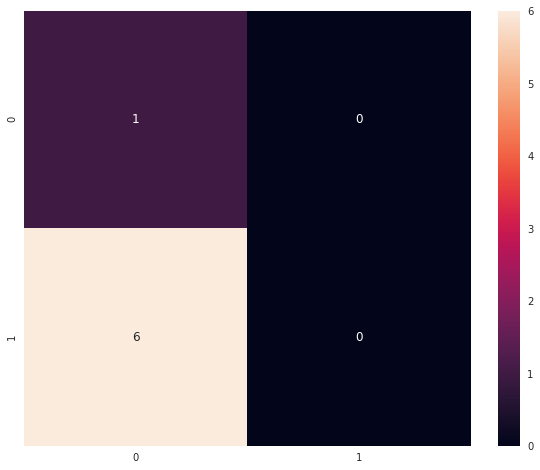

In [185]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

In [51]:
# Let's partition the data!
# We will train your model on 80% of the data and validate it on 20% of the remaining training data.
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(images,
                                                             images,
                                                             test_size=0.2,
                                                             random_state=13)

# Shapes of training set
print("Dataset (images) shape: {shape}".format(shape=images.shape))

Dataset (images) shape: (1952, 63, 76, 1)


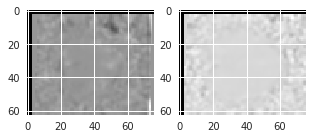

In [57]:
# Now, let's take a look at couple of the training and validation images in our dataset:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_X[15], (63,76))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(valid_X[10], (63,76))
plt.imshow(curr_img, cmap='gray')